By Drilon & Chia-Hua

For installing torchsummary use `pip install torchsummary`

In [14]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

## Multinomial Classification of MNIST 

1. Load the MNIST dataset by clicking through the first cells and see how to depict some samples. Please note that a training and a test dataset are loaded. Make sure that only the training set will be used for training and the test dataset just for evaluation (accuracy). 
2. Implement the multinomial logistic regression model by completing the code in the functions \verb|linear_trsf|, \verb|softmax|, \verb|predict|, \verb|loss_ce|, \verb|cost_ce|. 
3. Implement the mini-batch gradient descent training loop configured by number of epochs, batch size and learning rate. Implement the gradient explicitly (without autograd). Train the model with \verb|nepochs=10|, \verb|nbatch=64| and \verb|lr=0.01|. 
4. Tune learning rate and batch size and qualitatively characterise the behaviour. What is your favorite combination (learning rate, batch size, number of epochs)
5. Build and train the model with full-fledge pytorch incl. autograd. Implement a model class inheriting from $torch.nn.Module$ and use the layer functionality in the package $torch.nn$ (see lecture). Prove that you obtain the same accuracy.


#### Hints 
* Keep an eye on the shapes of the tensors (as passed into the functions and as used within the functions (and declared in the function descriptions).
* For each implemented function, run a small test with dummy input tensors (of the required shape) and check whether it outputs a tensor with expected shape and no 'nan'.
* Possibly, add \verb|assert()| statements in the code.
* For the training loop perform a training with only a single batch of size 64. Here, you should be able to obtain 100% training accuracy.

### 1. Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [15]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [16]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [17]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

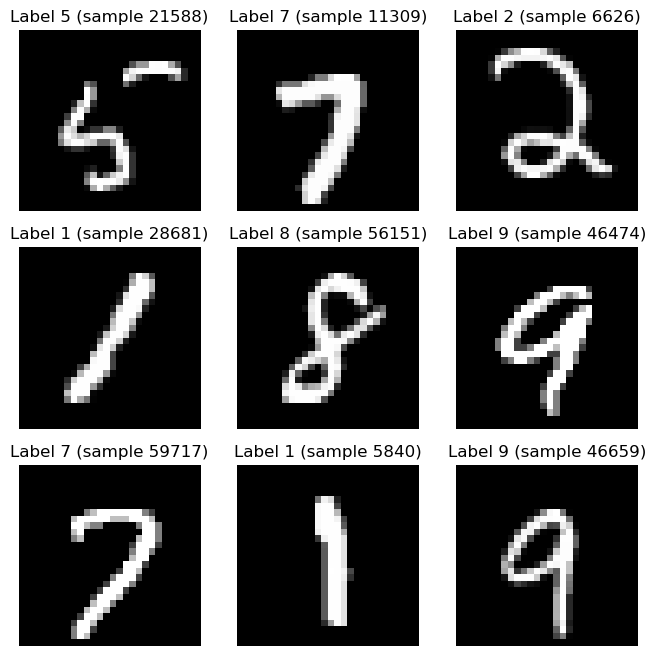

In [18]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [19]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [20]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


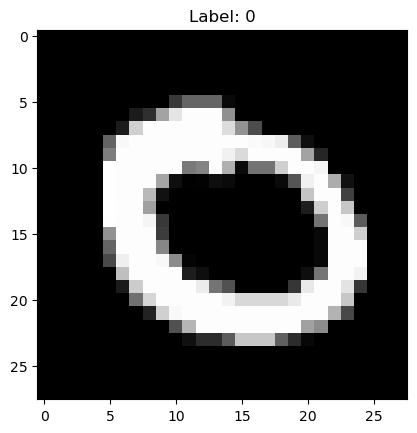

In [21]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### 2. Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [22]:
def linear_trsf(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    x_flattened = x.view(x.shape[0], -1)
    return torch.matmul(x_flattened, W.t()) + b
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    # YOUR CODE (START)
    e_z = torch.exp(z - z.max(dim=1, keepdim=True).values)
    return e_z / e_z.sum(dim=1, keepdim=True)
    # YOUR CODE (END)
    
def predict(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    z = linear_trsf(x, W, b)
    return softmax(z)
    # YOUR CODE (END)


##### TEST

In [23]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape,b.shape)
u = predict(x,W,b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 0.9999999403953552


#### Loss Function

In [31]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)
    y = y.long()
    predicted_probabilities = uhat[range(uhat.shape[0]), y.view(-1)]
    loss = -torch.log(predicted_probabilities + 1e-9)  # preventing log of 0
    return loss
    
    # YOUR CODE (END)

def cost_ce(y,uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    sample_losses = loss_ce(y, uhat)
    mean_loss = sample_losses.mean()
    return mean_loss
    # YOUR CODE (END)


##### TEST

In [25]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2,3],[2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### 3. Mini-Batch Gradient Descent

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [26]:
def grad_loss_ce(x,u,uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    grad_output = uhat - u
    gradW = torch.matmul(grad_output.t(), x.reshape(x.shape[0], -1))

    gradb = grad_output.sum(dim=0, keepdim=True)
    return gradW, gradb
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [27]:
def metrics(X,Y,W,b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)
    
    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START)    
    Y = Y.view(-1).long()
    uhat = predict(X, W, b)

    cost = cost_ce(Y, uhat)

    _, predicted_labels = torch.max(uhat, 1)
    correct_predictions = (predicted_labels == Y).float()
    acc = correct_predictions.mean()

    return cost.item(), acc.item()
    # YOUR CODE (END)

#### Training

In [34]:
nepochs = 10
alpha = 0.01
nclasses = 10
nbatch = 64
num_batches = len(training_data)/float(nbatch)

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []

train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 
W,b = torch.randn((10,28*28)), torch.zeros((1,10))

d0 = datetime.now()

for epoch in range(nepochs):
    cost_accum = 0.0
    correct = 0
    total = 0

    for X, Y in train_dataloader:
        Y_flattened = Y.view(-1, 1)
        Y_pred_prob = predict(X, W, b)

        loss = cost_ce(Y, Y_pred_prob)
        cost_accum += loss.item() * X.size(0)

        Y_one_hot = torch.nn.functional.one_hot(Y, num_classes=nclasses).to(torch.float32)
        gradW, gradb = grad_loss_ce(X, Y_pred_prob, Y_one_hot)

        W -= alpha * gradW
        b -= alpha * gradb

        _, predicted_labels = torch.max(Y_pred_prob, 1)
        total += Y.size(0)
        correct += (predicted_labels == Y).sum().item()

    cost = cost_accum / total
    acc = correct / total

    Ytest_pred_prob = predict(Xtest, W, b)
    cost_test, acc_test = metrics(Xtest, Ytest.view(-1, 1), W, b)

    cost_hist.append(cost)
    acc_hist.append(acc)
    cost_hist_test.append(cost_test)
    acc_hist_test.append(acc_test)

    print(f"Epoch {epoch}: Train Cost {cost:.4f}, Train Acc {acc:.4f}, Test Cost {cost_test:.4f}, Test Acc {acc_test:.4f}")
    
d = datetime.now()
print((d-d0).total_seconds()/nepochs)  

Epoch 0: Train Cost 18.6509, Train Acc 0.0984, Test Cost 18.7380, Test Acc 0.0958
Epoch 1: Train Cost 18.6793, Train Acc 0.0986, Test Cost 18.7380, Test Acc 0.0958
Epoch 2: Train Cost 18.6793, Train Acc 0.0986, Test Cost 18.7380, Test Acc 0.0958
Epoch 3: Train Cost 18.6793, Train Acc 0.0986, Test Cost 18.7380, Test Acc 0.0958
Epoch 4: Train Cost 18.6793, Train Acc 0.0986, Test Cost 18.7380, Test Acc 0.0958
Epoch 5: Train Cost 18.6793, Train Acc 0.0986, Test Cost 18.7380, Test Acc 0.0958
Epoch 6: Train Cost 18.6793, Train Acc 0.0986, Test Cost 18.7380, Test Acc 0.0958
Epoch 7: Train Cost 18.6793, Train Acc 0.0986, Test Cost 18.7380, Test Acc 0.0958
Epoch 8: Train Cost 18.6793, Train Acc 0.0986, Test Cost 18.7380, Test Acc 0.0958
Epoch 9: Train Cost 18.6793, Train Acc 0.0986, Test Cost 18.7380, Test Acc 0.0958
8.5732451


(0.0, 10.0)

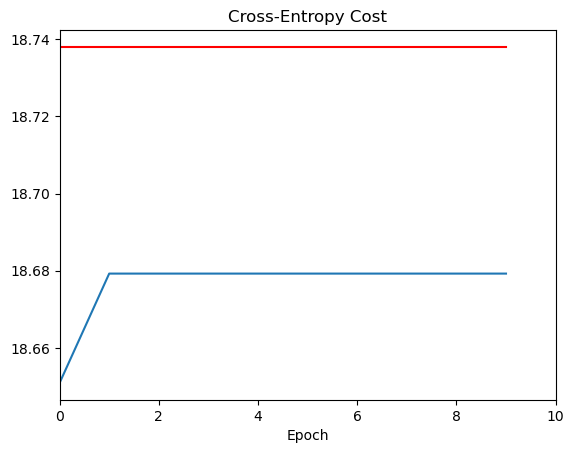

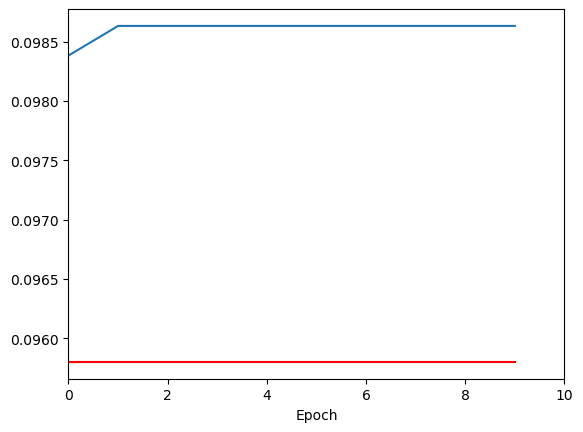

In [36]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
# plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
# plt.ylim(0.8,1)

#### This doesn't seem right...

### 4. Tune learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Explain the behavior.

Epoch 0: Train Cost 18.7016, Train Acc 0.0973, Test Cost 18.6882, Test Acc 0.0982
Epoch 1: Train Cost 18.7055, Train Acc 0.0974, Test Cost 18.6882, Test Acc 0.0982
Epoch 2: Train Cost 18.7055, Train Acc 0.0974, Test Cost 18.6882, Test Acc 0.0982
Epoch 3: Train Cost 18.7055, Train Acc 0.0974, Test Cost 18.6882, Test Acc 0.0982
Epoch 4: Train Cost 18.7055, Train Acc 0.0974, Test Cost 18.6882, Test Acc 0.0982
Epoch 5: Train Cost 18.7055, Train Acc 0.0974, Test Cost 18.6882, Test Acc 0.0982
Epoch 6: Train Cost 18.7055, Train Acc 0.0974, Test Cost 18.6882, Test Acc 0.0982
Epoch 7: Train Cost 18.7055, Train Acc 0.0974, Test Cost 18.6882, Test Acc 0.0982
Epoch 8: Train Cost 18.7055, Train Acc 0.0974, Test Cost 18.6882, Test Acc 0.0982
Epoch 9: Train Cost 18.7055, Train Acc 0.0974, Test Cost 18.6882, Test Acc 0.0982


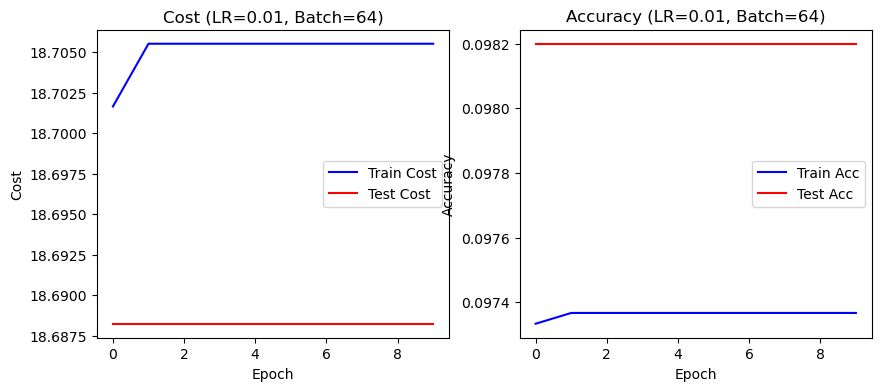

In [37]:
def run_experiment(alpha, nbatch, nepochs):
    W, b = torch.randn((10, 28*28)), torch.zeros((1, 10))

    train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    Xtest, Ytest = next(iter(DataLoader(test_data, batch_size=10000)))

    cost_hist, acc_hist, cost_hist_test, acc_hist_test = [], [], [], []

    for epoch in range(nepochs):
        cost_accum, correct, total = 0.0, 0, 0
        for X, Y in train_dataloader:
            Y_pred_prob = predict(X, W, b)
            loss = cost_ce(Y, Y_pred_prob)

            Y_one_hot = torch.nn.functional.one_hot(Y, num_classes=10).float()
            gradW, gradb = grad_loss_ce(X, Y_pred_prob, Y_one_hot)
            W -= alpha * gradW
            b -= alpha * gradb

            cost_accum += loss.item() * X.size(0)
            _, predicted_labels = torch.max(Y_pred_prob, 1)
            total += Y.size(0)
            correct += (predicted_labels == Y).sum().item()

        avg_cost = cost_accum / total
        acc = correct / total
        cost_hist.append(avg_cost)
        acc_hist.append(acc)

        cost_test, acc_test = metrics(Xtest, Ytest.view(-1, 1), W, b)
        cost_hist_test.append(cost_test)
        acc_hist_test.append(acc_test)

        print(f"Epoch {epoch}: Train Cost {avg_cost:.4f}, Train Acc {acc:.4f}, Test Cost {cost_test:.4f}, Test Acc {acc_test:.4f}")


    # plotting results
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(torch.arange(nepochs), cost_hist, "b-", label="Train Cost")
    plt.plot(torch.arange(nepochs), cost_hist_test, "r-", label="Test Cost")
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.title(f"Cost (LR={alpha}, Batch={nbatch})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(torch.arange(nepochs), acc_hist, "b-", label="Train Acc")
    plt.plot(torch.arange(nepochs), acc_hist_test, "r-", label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy (LR={alpha}, Batch={nbatch})")
    plt.legend()
    plt.show()

alpha = 0.01
nbatch = 64
nepochs = 10
run_experiment(alpha, nbatch, nepochs)

With this function, we could setup different experimental values and see how the training evolves. Unfortunately there seems something off, so i just write what we would expect:

**Learning Rate Impact:**
- **Low**: Leads to gradual learning, reducing the risk of overshooting the minimum loss but might need more time to converge to high accuracy.
- **Medium**: Offers a balanced approach that accelerates learning while maintaining a good chance of reaching high accuracy efficiently.
- **High**: Can speed up the initial learning phase significantly but risks overshooting the optimal point, potentially causing the model's performance to become unstable or even deteriorate.

**Batch Size Impact:**
- **Small**: Provides the model with more immediate feedback, allowing for faster adjustments but with a higher chance of fluctuations in learning progress due to the higher variability in smaller sample sets.
- **Medium**: Strikes a balance between learning speed and stability, making it a reliable choice for consistent training progress.
- **Large**: Smoothens the learning curve by reducing variance in updates, which can lead to more predictable training outcomes but may slow down the learning process and require more iterations to reach optimal performance.

### 5. With Full-Fledge PyTorch

In [38]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(28*28, 10)
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        x = self.flatten(x)
        z = self.linear(x)
        return z


In [39]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [40]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [41]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

model = NeuralNetwork()
for epoch in range(nepochs):
    model.train()
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        optimizer.zero_grad()
        pred = model(X)
        loss = cost_ce(pred, Y)
        loss.backward()
        optimizer.step()

        cost += loss.item()
        acc += (pred.argmax(1) == Y).type(torch.float).sum().item()

    cost /= nbatches
    acc /= size

    model.eval()
    with torch.no_grad():
        pred_test = model(Xtest)
        cost_test = cost_ce(pred_test, Ytest).item()
        acc_test = (pred_test.argmax(1) == Ytest).type(torch.float).sum().item() / len(Ytest)

    print(f"Epoch {epoch}: Train Cost {cost:.4f}, Train Acc {acc:.4f}, Test Cost {cost_test:.4f}, Test Acc {acc_test:.4f}")
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)

Epoch 0: Train Cost 2.3287, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943
Epoch 1: Train Cost 2.3287, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943
Epoch 2: Train Cost 2.3288, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943
Epoch 3: Train Cost 2.3287, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943
Epoch 4: Train Cost 2.3287, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943
Epoch 5: Train Cost 2.3287, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943
Epoch 6: Train Cost 2.3287, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943
Epoch 7: Train Cost 2.3287, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943
Epoch 8: Train Cost 2.3287, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943
Epoch 9: Train Cost 2.3287, Train Acc 0.0960, Test Cost 2.3267, Test Acc 0.0943


Text(0.5, 1.0, 'Accuracy')

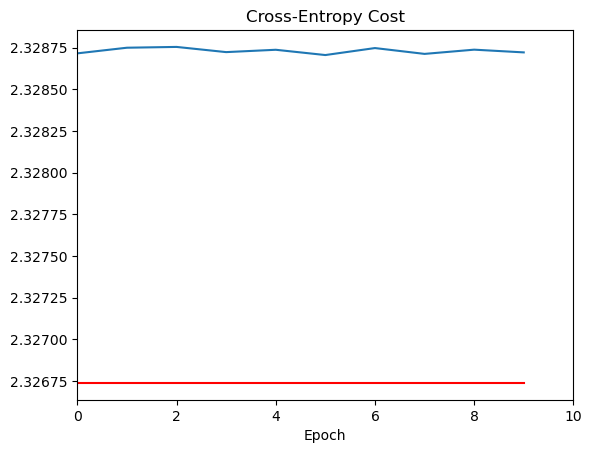

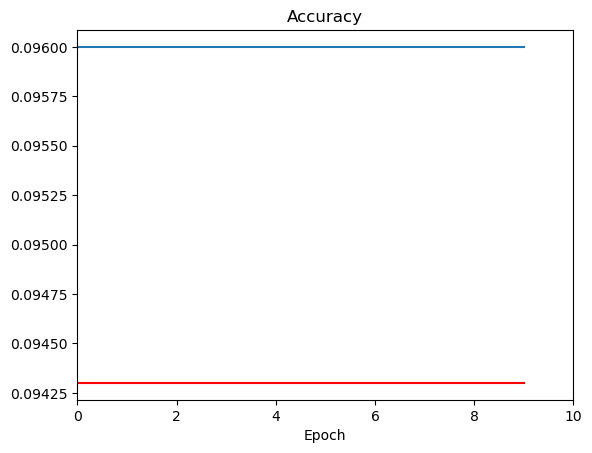

In [43]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
#plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
#plt.ylim(0.8,1)
plt.title("Accuracy")

again some weird output..